In [22]:
from tdt_autopsy.logregs_extra_experiments import tidy_results
from ipythonme import *
import pandas as pd
import os.path as op
pd.set_option('precision', 2)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 12)
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

# Parameter selection and model blending for workflow 2

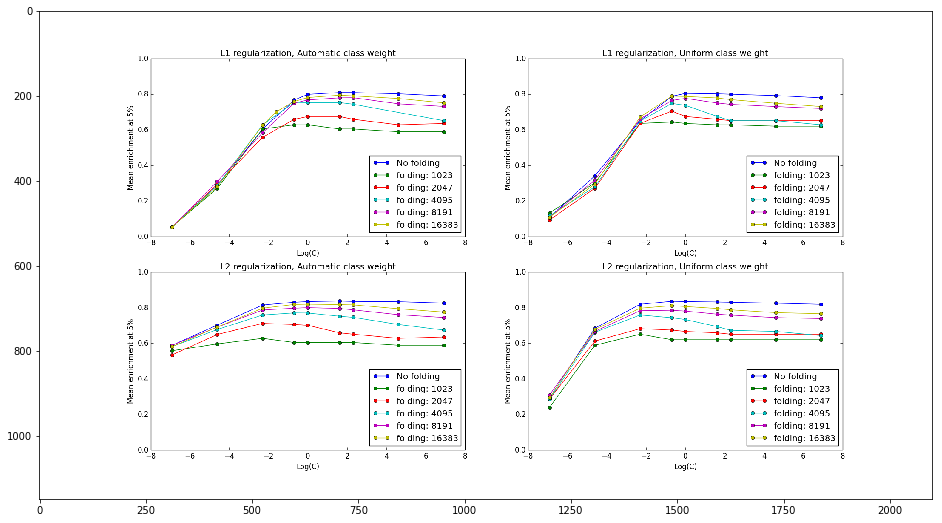

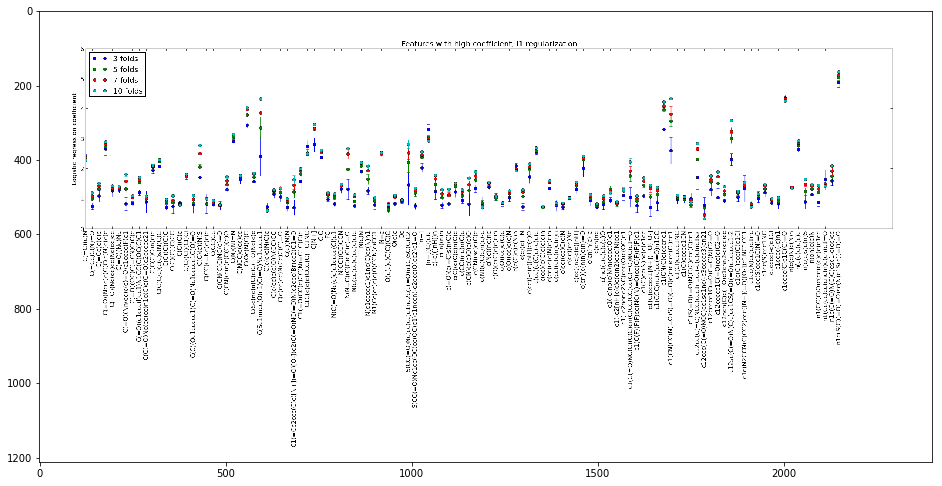

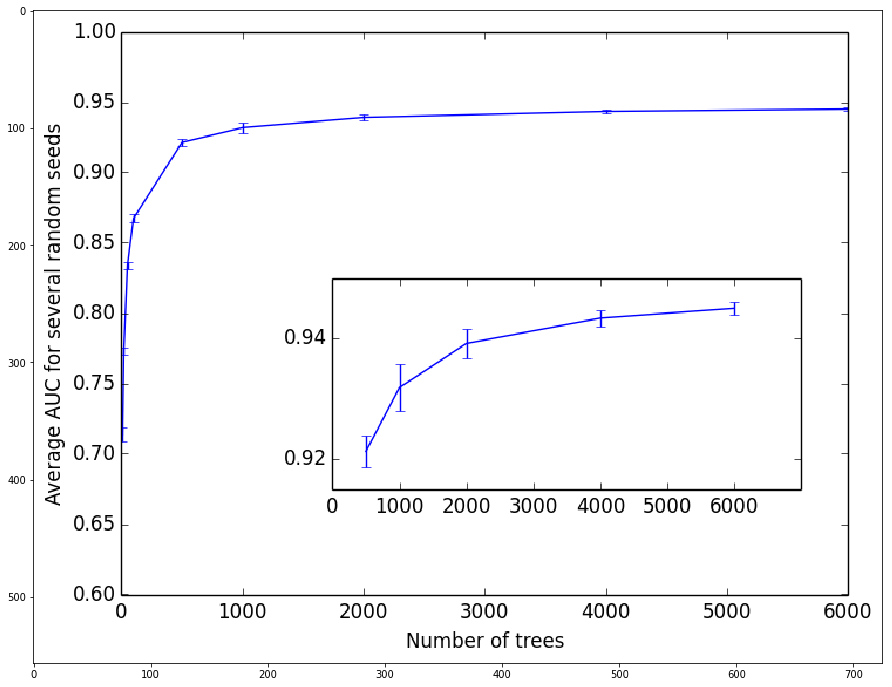

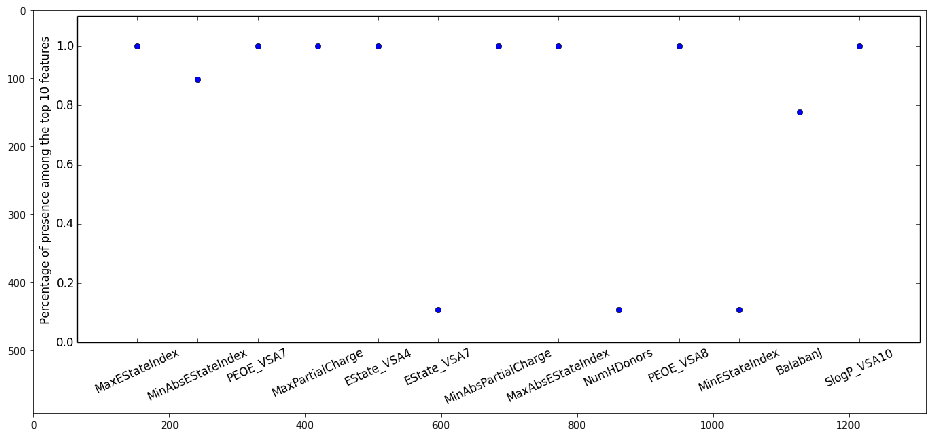

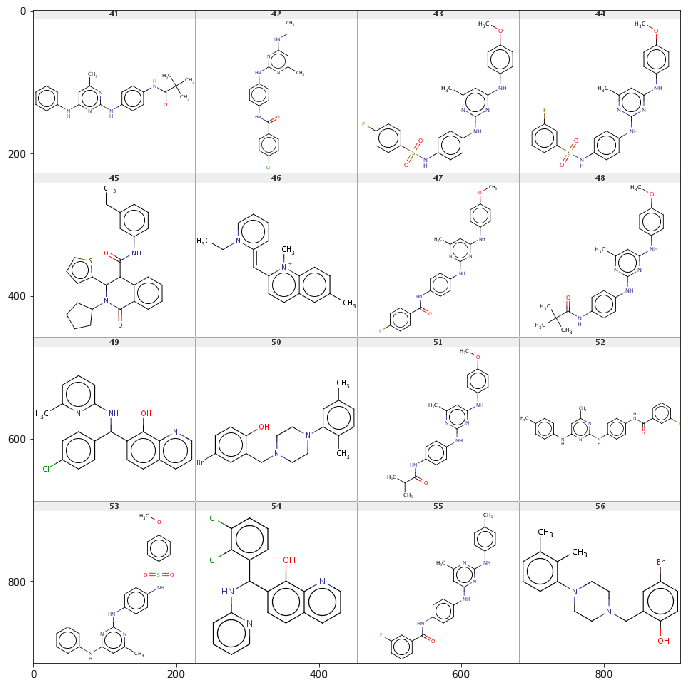

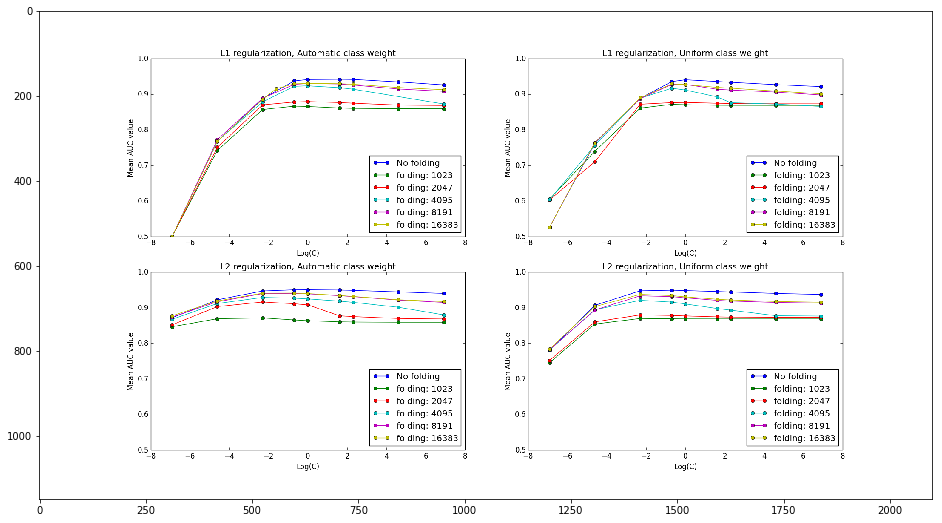

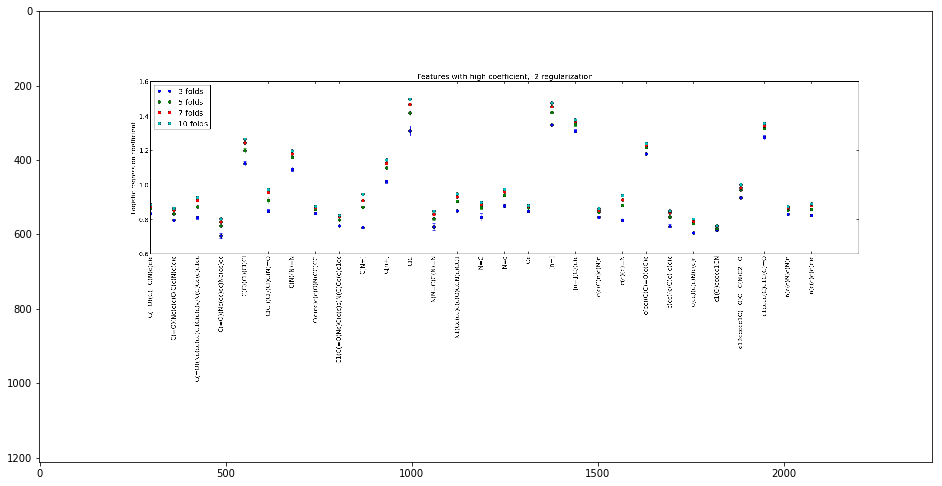

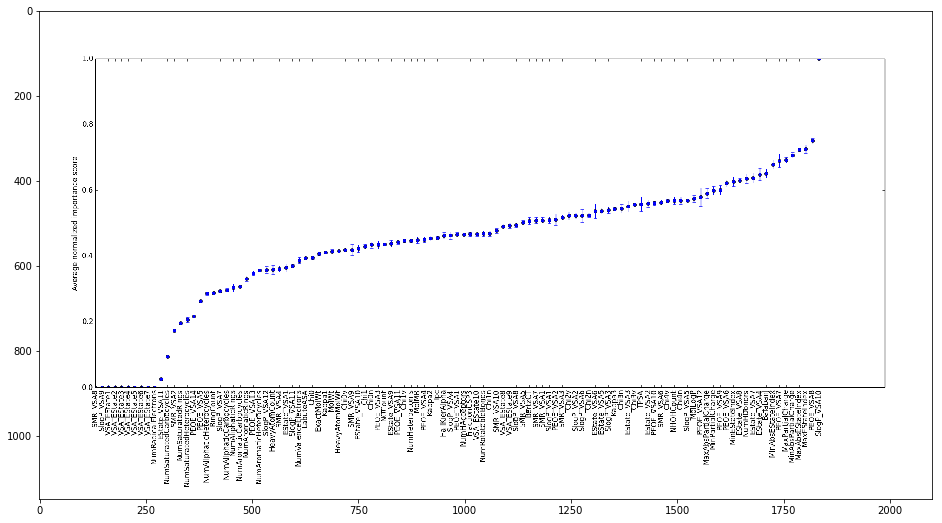

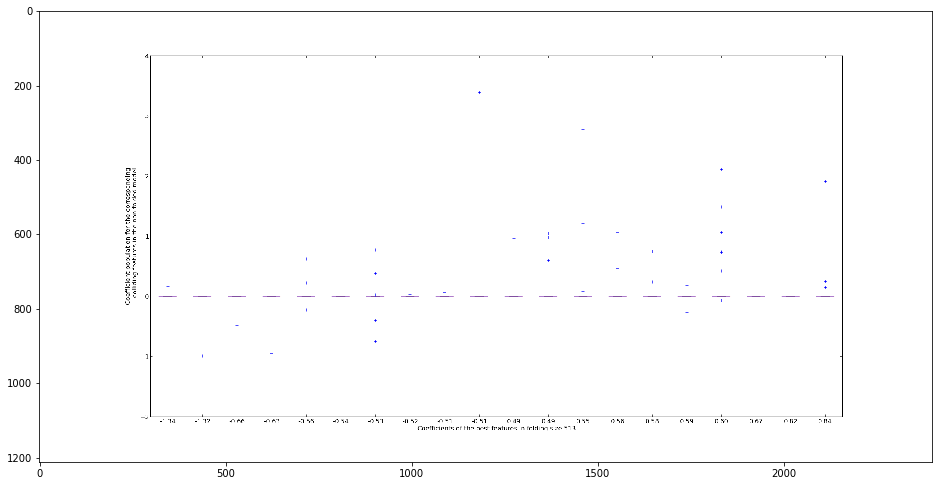

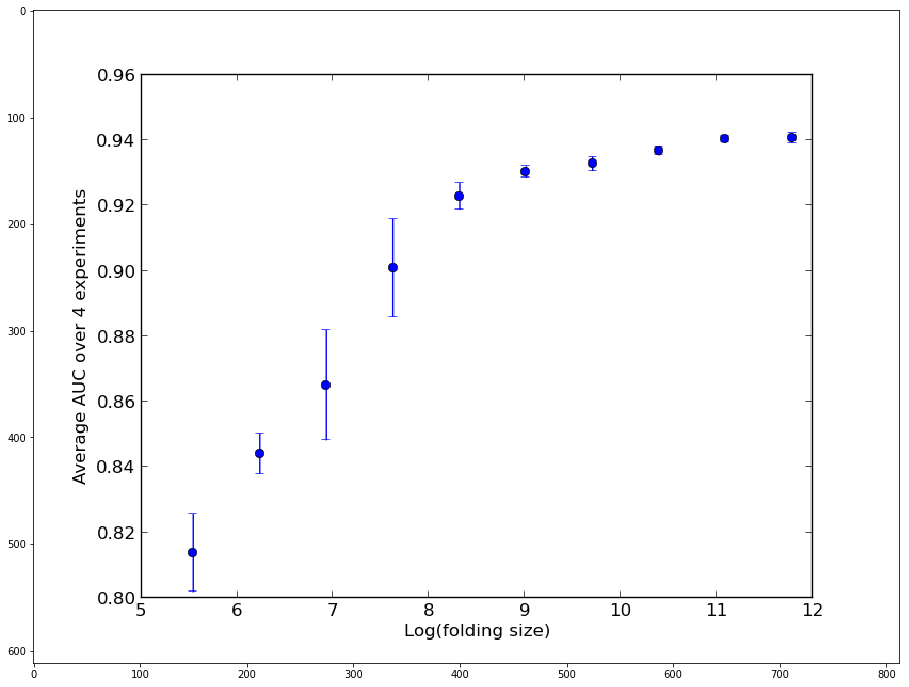

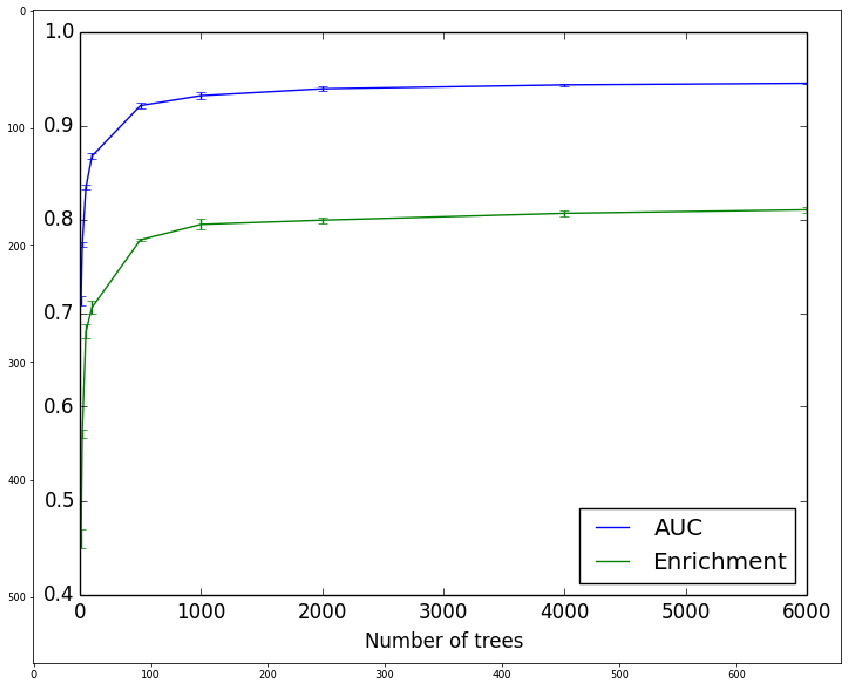

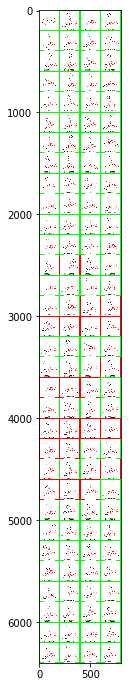

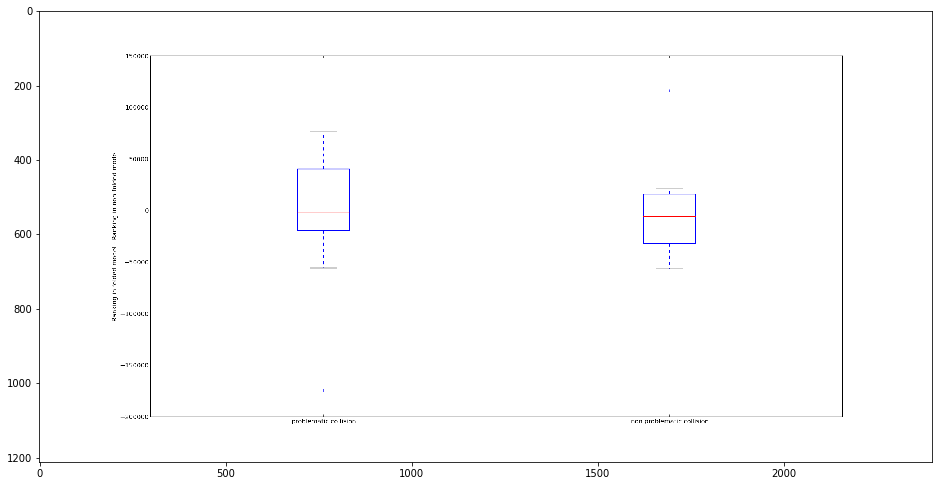

In [18]:
# show_image('./images/workflow2-tutorial/Analysis_task2_auc_fs.png')

images_tutorial_root = './images/workflow2-tutorial/'

images_present = (
    'Analysis_task1_enrichment.png',
    'Analysis_task3_l1.png',
    'AUC_f_numtrees.png',
    'occurrences_features_top10.png',
    'selected_screening.png',
    'Analysis_task1.png',
    'Analysis_task3_l2.png',
    'mean_feat_importances.png',
    'Population_nonfolded_feats_fs=513.png',
    'Analysis_task2_auc_fs.png',
    'AUC_and_enrichment_f_numtrees.png',
    'Mols_having_best_fpt.png',
    'Ranking_differences_in_pb_and_nonpb_foldedbits.png',
)

for image in images_present:
    info(image)
    show_image(op.join(images_tutorial_root, image))


# Revisiting the competition dataset

# A discussion of folding stupidities

The hashing trick allows scalable learning on large datasets blah. Hashing happens in two phases: map to an integer (few collisions) and folding (many more collisions).

In [ ]:
# Do fingerprint counts follow a Zipf distribution?
# Gradual growth of the feature space

In [19]:
# Let's load the very anecdotical results from the competition benchmark
#   - Train on the whole training set with the best individual logreg
#   - Test in the tiny competition set (1056 mols, around 100 positives)
#     Anecdotical, but gives us the prize and agrees with more serious cross-val + OOB evaluations.
df = tidy_results(recompute=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 33 columns):
data_name                    4064 non-null object
model_name                   4064 non-null object
zero_columns                 4064 non-null object
binarize_threshold           4064 non-null float64
input_is_binary              4064 non-null bool
is_binary                    4064 non-null bool
is_binary_counts             4064 non-null bool
is_regular_counts            4064 non-null bool
allow_unseen_in_folding      4064 non-null bool
fold_size                    4064 non-null int64
fold_seed                    4064 non-null object
num_fold_seeds               4064 non-null int64
min_radius                   4064 non-null float64
max_radius                   4064 non-null float64
row_normalizer               4064 non-null object
scale                        4064 non-null bool
auc                          4064 non-null float64
enrichment_1                 4064 non-null float64
en

In [20]:
# We will only look at L2-regularized networks (training with L1 penalty takes much longer to worse results)
# df = df.query('model_name == "tdtl2"')
# Also we will remove binarize + fold counts
# These are binarized matrices that become counts on folding
# (each bucket counts the number of substructures going them without taking into account their counts)
# It works well, but I do not think it is common practice, so for the time being I let them out
# df = df.query('is_binary or is_regular_counts')

In [21]:
# The table looks like this...
show_df(df.sort_values('auc', ascending=False).head(5))

data_name,model_name,zero_columns,binarize_threshold,input_is_binary,is_binary,is_binary_counts,is_regular_counts,allow_unseen_in_folding,fold_size,fold_seed,num_fold_seeds,min_radius,max_radius,row_normalizer,scale,auc,enrichment_1,enrichment_5,enrichment_10,bedroc20,rie20,pre_column_manipulation_s,fit_s,predict_s,eval_s,total_s,id,model_sparsity,model,folder,fold_as_binary,unfolded
competition-external,tdtl2,transductive,0.00,True,False,True,False,False,32767,3,1,-inf,inf,none,False,0.85,5.70,5.33,4.54,0.50,4.50,0.04,163.29,3.45,1.02e-02,166.80,855eaf733620033bf715ec02f3a50ea57538fb2b,0.0,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('binarize',FastBinarizer(copy=True)),('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)",False,False
competition-external,tdtl2,transductive,0.00,True,True,False,False,False,32767,3,1,-inf,inf,none,False,0.85,5.70,5.33,4.54,0.51,4.56,0.03,111.36,1.90,6.76e-03,113.30,f74613662555e8f5aab8d46443fc73bb48f2bbf2,0.0,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('binarize',FastBinarizer(copy=True)),('fold',Folder(as_binary=True,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=True,as_float=False,fold_size=32767,positive=True,seed=3)",True,False
competition-external,tdtl2,transductive,inf,False,False,False,True,False,32767,3,1,-inf,inf,none,False,0.84,6.65,5.13,4.34,0.50,4.43,0.02,210.16,3.56,1.15e-02,213.76,c00b9701aaa61135d10a771319dc760645d05770,0.0,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)",False,False
competition-external,tdtl2,none,inf,False,False,False,True,False,32767,3,1,-inf,inf,none,False,0.84,5.70,5.13,4.14,0.50,4.44,0.03,212.98,0.12,9.05e-03,213.14,604ccc2ee76f17c5b6504dbc4d4c2f4ee9c3334f,0.0,"Pipeline(memory=None,steps=[('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)",False,False
competition-external,tdtl2,none,0.00,True,False,True,False,False,32767,3,1,-inf,inf,none,False,0.84,4.75,4.93,4.24,0.50,4.42,0.03,95.20,0.08,7.31e-03,95.32,3d2948b426938ae44032b4f119e8466b88533f37,0.0,"Pipeline(memory=None,steps=[('binarize',FastBinarizer(copy=True)),('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)",False,False


In [10]:
# Lets look at:
# counts vs binary (remember, still not implemented for folding) 
#   => irrelevant for non folding (most values are 1 anyway)
#      result might differ enormously when we allow folding counts
# whether we allow unseen features to add noise in folding
#   => large effect when folding to usual sizes (1024, 2048, 4096)
#      N.B. should we had any small effect of folding seed for no folding, 
#      it would be due to liblinear uncontrollable seed:
#        https://github.com/scikit-learn/scikit-learn/issues/365
#   => the effect is smaller as fold size grows
# how we normalize each row
#   => showed no effect, so to make things more easily graspable, I have moved it to
#      the query from the groupby (look at it back when we add counts to folding)
df.query('not scale and '
         'max_radius > 1000000 and '
         'zero_columns == "none" and '
         'row_normalizer == "none" and '
         'num_fold_seeds < 2').groupby(['fold_size',
                                        'is_binary',
                                        'allow_unseen_in_folding']).auc.describe()

count  mean       std   min  \
fold_size  is_binary allow_unseen_in_folding                                
511        False     False                    4.0    0.71  1.55e-02  0.69   
                     True                     4.0    0.70  2.22e-02  0.67   
           True      False                    4.0    0.69  2.25e-02  0.66   
                     True                     4.0    0.67  3.27e-02  0.63   
1023       False     False                    4.0    0.74  1.70e-02  0.72   
                     True                     4.0    0.73  2.31e-02  0.70   
           True      False                    4.0    0.73  1.89e-02  0.71   
                     True                     4.0    0.71  2.21e-02  0.70   
2047       False     False                    4.0    0.74  1.56e-02  0.72   
                     True                     4.0    0.72  1.28e-02  0.71   
           True      False                    4.0    0.73  1.39e-02  0.71   
                     True                     4.0    0.71  1.70e-02  0.69   
4091       False     False                    4.0    0.78  1.21e-02  0.77   
                     True                     4.0    0.74  1.73e-02  0.72   
           True      False                    4.0    0.77  1.16e-02  0.76   
                     True                     4.0    0.73  1.59e-02  0.71   
8191       False     False                    4.0    0.80  1.84e-02  0.77   
                     True                     4.0    0.78  1.51e-02  0.75   
           True      False                    4.0    0.80  1.83e-02  0.78   
                     True                     4.0    0.78  1.34e-02  0.76   
16383      False     False                    4.0    0.81  1.08e-02  0.80   
                     True                     4.0    0.79  5.84e-03  0.79   
           True      False                    4.0    0.81  1.37e-02  0.80   
                     True                     4.0    0.79  7.70e-03  0.79   
32767      False     False                    4.0    0.82  2.24e-02  0.79   
                     True                     4.0    0.81  2.21e-02  0.79   
           True      False                    4.0    0.82  2.06e-02  0.79   
                     True                     4.0    0.82  2.15e-02  0.79   
4294967295 False     False                    1.0    0.84 NaN        0.84   
                     True                     1.0    0.84 NaN        0.84   
           True      False                    1.0    0.83 NaN        0.83   
                     True                     1.0    0.83 NaN        0.83   

                                               25%   50%   75%   max  
fold_size  is_binary allow_unseen_in_folding                          
511        False     False                    0.70  0.71  0.72  0.72  
                     True                     0.69  0.70  0.71  0.72  
           True      False                    0.68  0.70  0.71  0.71  
                     True                     0.65  0.67  0.69  0.71  
1023       False     False                    0.72  0.73  0.74  0.76  
                     True                     0.71  0.72  0.73  0.76  
           True      False                    0.72  0.72  0.73  0.75  
                     True                     0.70  0.70  0.72  0.74  
2047       False     False                    0.73  0.74  0.75  0.76  
                     True                     0.72  0.73  0.73  0.74  
           True      False                    0.73  0.74  0.74  0.74  
                     True                     0.71  0.72  0.72  0.72  
4091       False     False                    0.77  0.78  0.79  0.80  
                     True                     0.73  0.74  0.75  0.76  
           True      False                    0.76  0.77  0.78  0.78  
                     True                     0.72  0.73  0.74  0.75  
8191       False     False                    0.79  0.80  0.81  0.81  
                     True                     0.77  0.78  0.78  0.79  
       

In [11]:
# Or more focused
df.query('max_radius > 1000000 and '
         'fold_size == 4091 and '
         'zero_columns == "none" and '
         'num_fold_seeds < 2 and '
         'not scale and '
         'row_normalizer == "none"').groupby('allow_unseen_in_folding').auc.mean()


allow_unseen_in_folding
False    0.78
True     0.74
Name: auc, dtype: float64

In [12]:
# What about the max radius?
#  - For small fold sizes, larger radii have no to detrimental effect => Due to growing collision rate?
#  - For large fold sizes and no fold, the model is able to figure out how not to over fit too much => clear gains 
df.query('row_normalizer == "none" and '
         'zero_columns == "none" and '
         'num_fold_seeds < 2 and '
         'not scale').groupby(['fold_size', 
                               'is_binary',
                               'allow_unseen_in_folding',
                               'max_radius']).auc.describe()

count  mean  \
fold_size  is_binary allow_unseen_in_folding max_radius                
511        False     False                   2.00        4.0    0.71   
                                             3.00        4.0    0.72   
                                             4.00        4.0    0.70   
                                             inf         4.0    0.71   
                     True                    2.00        4.0    0.71   
                                             3.00        4.0    0.71   
                                             4.00        4.0    0.69   
                                             inf         4.0    0.70   
           True      False                   2.00        4.0    0.69   
                                             3.00        4.0    0.69   
                                             4.00        4.0    0.69   
                                             inf         4.0    0.69   
                     True                    2.00        4.0    0.69   
                                             3.00        4.0    0.69   
                                             4.00        4.0    0.68   
                                             inf         4.0    0.67   
1023       False     False                   2.00        4.0    0.73   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.74   
                                             inf         4.0    0.74   
                     True                    2.00        4.0    0.72   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.73   
                                             inf         4.0    0.73   
           True      False                   2.00        4.0    0.72   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.72   
                                             inf         4.0    0.73   
                     True                    2.00        4.0    0.71   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.72   
                                             inf         4.0    0.71   
2047       False     False                   2.00        4.0    0.77   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.74   
                                             inf         4.0    0.74   
                     True                    2.00        4.0    0.77   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.74   
                                             inf         4.0    0.72   
           True      False                   2.00        4.0    0.76   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.73   
                                             inf         4.0    0.73   
                     True                    2.00        4.0    0.76   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.73   
                                             inf         4.0    0.71   
4091       False     False                   2.00        4.0    0.79   
                                             3.00        4.0    0.79   
                                             4.00        4.0    0.80   
                                             inf         4.0    0.78   
                     True                    2.00        4.0    0.78   
                                             3.00        4.0    0.79   
                         

In [13]:
# What about scaling?
# What about removing duplicates ("representative columns")?
# What about hashing each substructure to different columns?
# What about L1 regularization (note that, as usual, it works worse than L2)?
# What about the same analysis with our original SMARTS feats? (computation needs to be better,
#   - What about completing with other substructures (e.g. our not so clever add FCFP to the mix?).
# What about just using FCFP itself?
# What about RF, now that sklearn supports CSR for building them?
# What about using the malaria dataset I mined out of chembl, so we can trust a bit more the results?
# What about speed differences between folded at different folds and unfolded?
#  - (might be surprising, as sparsity diminishes with smaller folds).

In [14]:
# Lets read the old results we have access to.
# In particular, we miss workflow1 model used for screening the commercial dataset
# (fingerprints with 4096 buckets, using their original monkey-patching weighting - which was detrimental)
from tdt_autopsy.eval import results_df
rdf = results_df().sort_values('auc', ascending=False).reset_index(drop=True)
# Rename to suit the paper's nomenclature for workflows
rdf.model = rdf.model.str.replace('ccl', 'workflow2').str.replace('sg', 'workflow1')
# Workflow 2 "only use last fold" bug makes no difference
# Let's just keep the intended "average all folds"
rdf = rdf[~rdf.model.str.contains('lastFold')].copy()
# Let's also remove workflow1 modern, as it is roughly the same as moderner
rdf = rdf.query('model != "workflow1_modern"')
rdf

,model,dataset,auc,enrichment_1,enrichment_5,enrichment_10,bedroc20,rie20
1,workflow2_logregs_avg_linr,competition_benchmark,0.83,7.60,4.73,3.55,0.47,4.16
2,workflow2_workflow1_blend,competition_benchmark,0.81,4.75,4.14,3.95,0.42,3.73
3,workflow1_moderner_4096,competition_benchmark,0.80,3.80,3.16,3.65,0.39,3.44
5,workflow1_moderner,competition_benchmark,0.79,4.75,3.95,3.25,0.39,3.48
7,workflow2_final_avg_avg,competition_benchmark,0.79,4.75,4.34,3.95,0.44,3.96
10,workflow2_final_avg_linr,competition_benchmark,0.79,3.80,4.34,3.65,0.42,3.78
11,workflow2_logregs_avg_avg,competition_benchmark,0.78,7.60,4.14,3.65,0.44,3.96
12,workflow2_trees_avg,competition_benchmark,0.76,3.80,4.54,3.55,0.42,3.73
13,workflow2_trees_linr,competition_benchmark,0.75,5.70,4.93,3.45,0.44,3.92
14,workflow1_old,competition_benchmark,0.75,2.85,2.96,2.76,0.32,2.88


In [15]:
# Also from table 3 in the paper
# Method, AUC, EF5%
# Workflow 1 - Fusion model (1024/2048 bits): 0.74, 2.76
# Workflow 1 - Fusion model (4096 bits) 0.75, 4.75
# Workflow 2: 0.79, 4.34

# Remember: enrichment measurements are specially dodgy with such small datasets
# Again, what was the difference between modern and moderner?

In [ ]:
# From rdkit. Enrichment = (num_pos_until_i / num_total_pos) * (num_molecules / i)
def CalcEnrichment(scores, col, fractions):
  """ Determines the enrichment factor for a set of fractions """
  numMol = len(scores)
  if numMol == 0:
    raise ValueError('score list is empty')
  if len(fractions) == 0:
    raise ValueError('fraction list is empty')
  for i in fractions:
    if i > 1 or i < 0:
      raise ValueError('fractions must be between [0,1]')

  numPerFrac = [math.ceil(numMol * f) for f in fractions]
  numPerFrac.append(numMol)
  numActives = 0
  enrich = []

  # loop over score list
  for i in range(numMol):
    if i > (numPerFrac[0] - 1) and i > 0:
      enrich.append(1.0 * numActives * numMol / i)
      numPerFrac.pop(0)
    active = scores[i][col]
    if active:
      numActives += 1

  if numActives > 0:  # check that there are actives
    enrich = [e / numActives for e in enrich]
  else:
    enrich = [0.0] * len(fractions)
  return enrich